## Function to get samples from a frequencies array

In [151]:
def get_samples(frequencies):
    X = []
    for i, frequency in enumerate(frequencies):
        for _ in range(frequency):
            X.append(i+1)
    return X

## Function to generate the KDE from a frequencies array

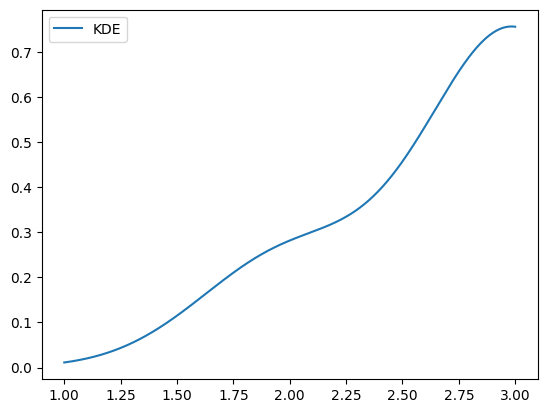

In [152]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def generate_kde(frequencies):

    # needed for arrays with only one component different from zero
    if np.count_nonzero(frequencies == 0) >= 2:
        for i in range(len(frequencies)):
            frequencies[i] += 1

    data = get_samples(frequencies)

    # Create KDE object
    kde = gaussian_kde(data, 'silverman')

    # Generate values for the KDE plot
    x_values = np.linspace(1, 3, 1000)
    kde_values = kde(x_values)

    return x_values, kde_values, kde

# Example: Generate PDF for the example distribution
x_values, kde_values, kde = generate_kde([0, 1, 3])

# Plot the KDE
plt.plot(x_values, kde_values, label='KDE')
plt.legend()
plt.show()

## Hermite Polynomial

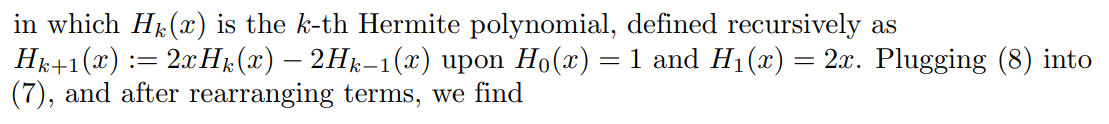

In [153]:
def hermite_polynomial(k, x):
    if k == 0:
        return 1
    elif k == 1:
        return 2 * x
    return 2 * x * hermite_polynomial(k-1, x) - 2 * hermite_polynomial(k-2, x)

print(hermite_polynomial(k=5, x=3))

6120


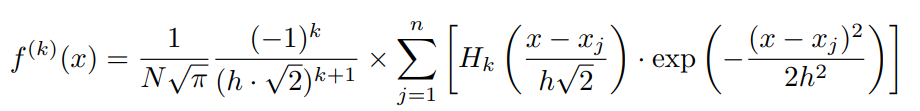

## kth-order Derivative of the KDE

In [154]:
def deriv_k(k, h, X, x):
    n = len(X)
    A = 1 / (n * np.sqrt(np.pi))
    B = ((-1) ** k) / ((h * np.sqrt(2)) ** (k + 1))
    C = 0

    Hk = hermite_polynomial
    for j in range(n):
        C += Hk(k, (x - X[j])/(h * np.sqrt(2))) * np.exp(-((x - X[j]) ** 2)/(2 * (h ** 2)))

    return A * B * C

## Paper Experiment

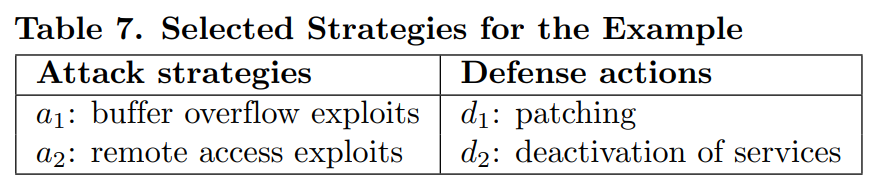

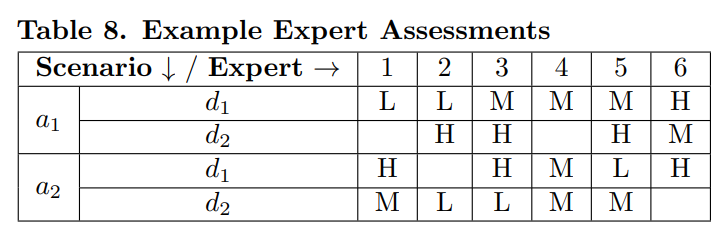

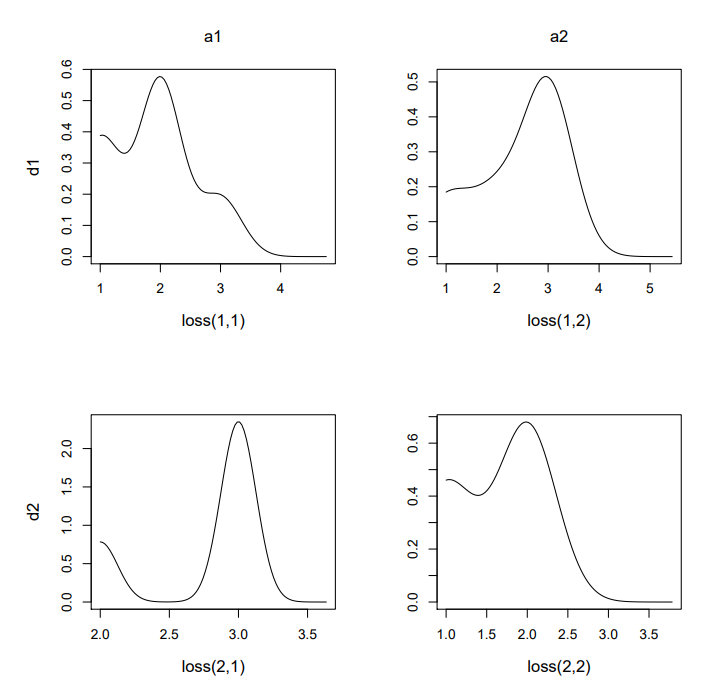

In [175]:
distributions_matrix = np.array([[[2, 3, 1], [1, 1, 3]], [[0, 1, 3], [2, 3, 0]]])

defender_strategies = ['patching', 'deactivation of services']
attacker_strategies = ['buffer overflow exploits', 'remote access exploits']

## Fictitious Play Matrices

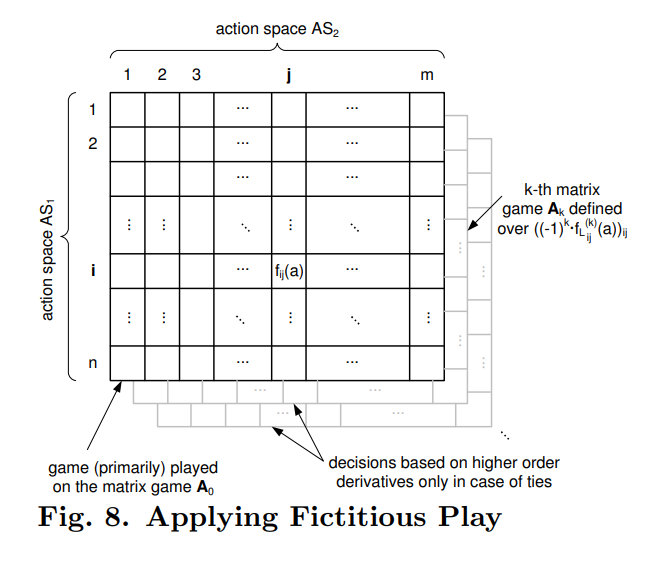

In [176]:
def generate_game_matrices(matrix):

    game_matrices = []

    data = []

    game_main_matrix = []
    for row in matrix:
        game_main_matrix_row = []
        data_row = []
        for distribution in row:
            x, y, kde = generate_kde(distribution)
            data_row.append((x, y))
            value = kde(3)[0]
            game_main_matrix_row.append(value)
        data.append(data_row)
        game_main_matrix.append(game_main_matrix_row)

    game_main_matrix = np.array(game_main_matrix)
    game_matrices.append(game_main_matrix)

    for k in range(1, 21):
        kth_matrix = []
        for row in matrix:
            kth_matrix_row = []
            for distribution in row:
                _, _, kde = generate_kde(distribution)
                z = (-1) ** k
                value = deriv_k(k, kde.silverman_factor(), get_samples(distribution), 3)
                kth_matrix_row.append(z * value)
            kth_matrix.append(kth_matrix_row)
        kth_matrix = np.array(kth_matrix)
        game_matrices.append(kth_matrix)

    game_matrices = np.array(game_matrices)

    return game_matrices, data

game_matrices, data = generate_game_matrices(distributions_matrix)

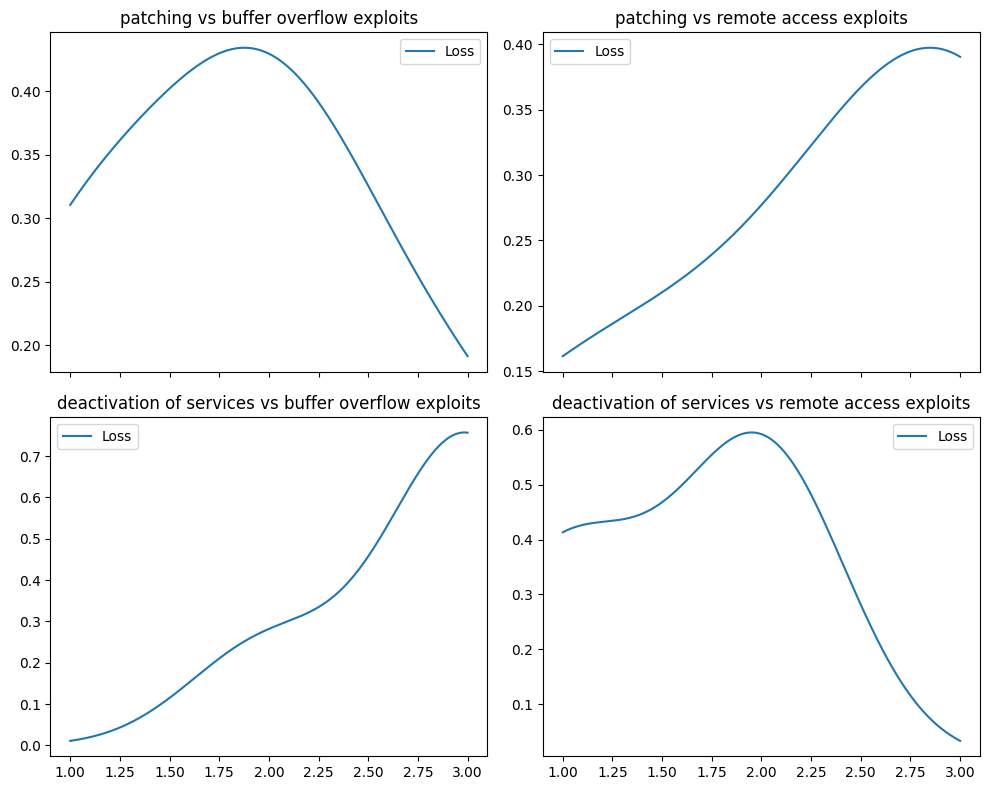

In [177]:
import matplotlib.pyplot as plt

def plot_KDE_curves(matrix, defender_strategies, attacker_strategies, size=(10, 8), title_fontsize=12):
    num_rows, num_cols = len(matrix), len(matrix[0])

    fig, axs = plt.subplots(num_rows, num_cols, figsize=size, sharex=True)

    for i in range(num_rows):
        for j in range(num_cols):
            x, y = matrix[i][j]

            # Plot curve
            axs[i, j].plot(x, y, label='Loss')

            axs[i, j].legend()
            axs[i, j].set_title(f'{defender_strategies[i][:30]} vs {attacker_strategies[j][:30]}', fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()

plot_KDE_curves(data, defender_strategies, attacker_strategies)

## Lexicographic Comparison of kth-order Derivatives

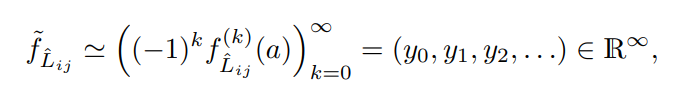

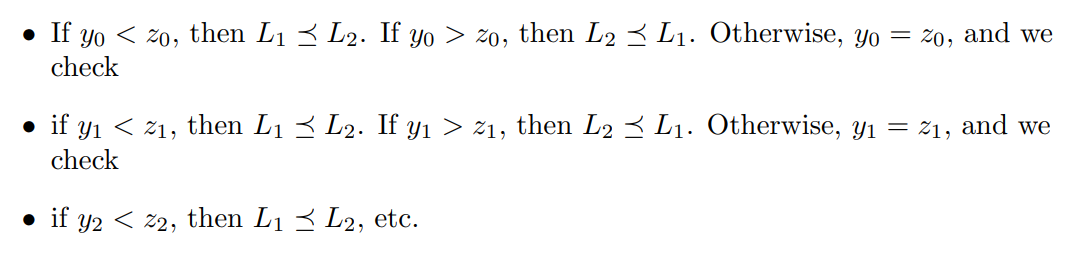

In [158]:
import numpy as np
from functools import reduce

def argmin_lex(matrix):
    num_cols = matrix.shape[1]

    def compare_columns(min_index, current_index):
        min_col = matrix[:, min_index]
        current_col = matrix[:, current_index]

        for a, b in zip(min_col, current_col):
            if a < b:
                return min_index
            elif a > b:
                return current_index
        return min_index

    min_lex_index = reduce(lambda x, y: compare_columns(x, y), range(num_cols))

    return min_lex_index

def argmax_lex(matrix):
    num_cols = matrix.shape[1]

    def compare_columns(max_index, current_index):
        max_col = matrix[:, max_index]
        current_col = matrix[:, current_index]

        for a, b in zip(max_col, current_col):
            if a < b:
                return current_index
            elif a > b:
                return max_index
        return max_index

    max_lex_index = reduce(lambda x, y: compare_columns(x, y), range(num_cols))

    return max_lex_index

M = np.array([[2, 2, 2], [3, 4, 2]])
result = argmin_lex(M) # column (2, 2)
print(result)
result = argmax_lex(M) # column (2, 4)
print(result)

2
1


## "Parallel" Fictitious Play Implementation

In [160]:
def fictitious_play(matrices):

    K = 1000
    n = len(matrices[0])
    m = len(matrices[:, 0])

    A = np.zeros(n) # defender strategies frequencies
    B = np.zeros(m) # attacker strategies frequencies

    matrix = matrices[0].copy()

    ROWS = []
    for matrix in matrices:
        ROWS.append(matrix[0].copy())

    rowmin_col = argmin_lex(np.array(ROWS)) # idx of col of min of row

    COLS = []
    for matrix in matrices:
        COLS.append(matrix[:, rowmin_col].copy())

    NEWROWS = []
    NEWCOLS = []

    for i in range(K):

        colmax_row = argmax_lex(np.array(COLS)) # idx of row of max of col
        A[colmax_row] += 1

        for matrix in matrices:
            NEWROWS.append(matrix[colmax_row, :].copy())

        for j, matrix in enumerate(matrices):
            ROWS[j] += NEWROWS[j]
        NEWROWS = []

        rowmin_col = argmin_lex(np.array(ROWS)) # idx of col of min of row
        B[rowmin_col] += 1

        for matrix in matrices:
            NEWCOLS.append(matrix[:, rowmin_col].copy())

        for j, matrix in enumerate(matrices):
            COLS[j] += NEWCOLS[j]
        NEWCOLS = []

    p_star = A / K
    q_star = B / K

    return p_star, q_star

p_star, q_star = fictitious_play(game_matrices)

print('Optimal Defense:\n')
for d_strategy, p_prob in zip(defender_strategies, p_star):
    print(f'{d_strategy}: {p_prob * 100}% of the time')

print('\n\nExpected Attack:\n')
for a_strategy, q_prob in zip(attacker_strategies, q_star):
    print(f'{a_strategy}: {q_prob * 100}% of the time')


Optimal Defense:

patching: 78.4% of the time
deactivation of services: 21.6% of the time


Expected Attack:

buffer overflow exploits: 37.8% of the time
remote access exploits: 62.2% of the time


## Topology Dependent Experiment

In [93]:
import networkx as nx
import random

def generate_random_topology(num_nodes):
    G = nx.Graph()

    # Define types of nodes
    node_types = ['workstation', 'router', 'server']

    # Add nodes to the graph with random types
    for i in range(num_nodes):
        node_type = random.choice(node_types)
        G.add_node(i, type=node_type)

    # Add random connections between nodes
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            # Add an edge with a certain probability
            if random.random() < 0.4:
                G.add_edge(i, j)

    # Ensure there is only one connected component
    while nx.number_connected_components(G) > 1:
        # Select two random nodes from different components and connect them
        components = list(nx.connected_components(G))
        node_in_component1 = random.choice(list(components[0]))
        node_in_component2 = random.choice(list(components[1]))
        G.add_edge(node_in_component1, node_in_component2)

    return G

In [78]:
def plot_topology(graph):
    # Define a dictionary to map node types to colors
    type_color_map = {
        'workstation': 'gold',
        'router': 'tomato',
        'server': 'lightskyblue'
    }

    # Extract node types for coloring
    node_types = [data['type'] for _, data in graph.nodes(data=True)]

    # Create a layout for the nodes
    pos = nx.spring_layout(graph)

    # Draw nodes with colors based on types
    node_colors = [type_color_map[node_type] for node_type in node_types]
    nx.draw(graph, pos, node_color=node_colors, with_labels=True, font_weight='bold')

    plt.title("Random System Topology")
    plt.show()

In [79]:
import json

with open('vulns_exploits.json', 'r') as json_file:
    vulns_exploits = json.load(json_file)

with open('exploits_controls.json', 'r') as json_file:
    exploits_controls = json.load(json_file)

In [80]:
def TVA(topology, vulns_exploits):
    tva_topology = topology.copy()

    for node, data in tva_topology.nodes(data=True):
        node_type = data['type']
        potential_exploits = []

        # Iterate over each vulnerability in the exploits dictionary
        for vulnerability, vulnerability_data in vulns_exploits.items():
            exploits_data = vulnerability_data.get('Exploits', [])
            targeted_nodes = vulnerability_data.get('Targeted Nodes', [])

            # Check if the node type is in the targeted nodes list for the vulnerability
            if node_type in targeted_nodes:
                potential_exploits.extend(exploits_data)

        # Randomly pick some exploits
        num_exploits_to_assign = random.randint(1, 3)
        selected_exploits = random.sample(potential_exploits, num_exploits_to_assign)

        # Assign potential exploits to the node
        tva_topology.nodes[node]['potential_exploits'] = selected_exploits

    return tva_topology

In [81]:
def find_paths(graph, node_a, node_b):
    try:
        # Find all simple paths between node_a and node_b
        paths = list(nx.all_simple_paths(graph, source=node_a, target=node_b))
        return paths
    except nx.NetworkXNoPath:
        # Handle the case where no paths exist between the nodes
        return []

In [136]:
import itertools

def get_attack_paths(paths, graph, num_attack_paths):
    attack_paths = []

    for path in paths:
        attack_path = []

        # Iterate over nodes in the path
        for i in range(len(path) - 1):
            current_node = path[i]
            next_node = path[i + 1]

            # Check if the current node has potential exploits
            current_exploits = graph.nodes[current_node].get('potential_exploits', [])

            # Check if the next node has potential exploits
            next_exploits = graph.nodes[next_node].get('potential_exploits', [])

            # Generate all possible combinations of exploits between current and next nodes
            exploit_combinations = list(itertools.product(current_exploits, next_exploits))

            # If it's the first node in the path, initialize the attack path with the exploits of the first node
            if i == 0:
                attack_path.extend([(exploit,) for exploit in current_exploits])

            # Multiply each attack path by the exploits of the next node
            attack_path = [attack + (exploit,) for attack in attack_path for exploit in next_exploits]

        attack_paths.extend(attack_path)

    # Ensure the number of attack paths required is not greater than the available attack paths
    num_attack_paths = min(num_attack_paths, len(attack_paths))

    # Randomly select num_attack_paths attack paths
    selected_attack_paths = random.sample(attack_paths, num_attack_paths)

    return selected_attack_paths

In [130]:
def get_controls(attack_paths, exploits_controls, num_controls_required):
    unique_exploits = set(exploit for attack_path in attack_paths for exploit in attack_path)
    available_controls = []

    for exploit in unique_exploits:
        if exploit in exploits_controls:
            available_controls.extend(exploits_controls[exploit]['Controls'])

    # Ensure the number of controls required is not greater than the available controls
    num_controls_required = min(num_controls_required, len(available_controls))

    # Randomly select num_controls_required controls
    selected_controls = random.sample(available_controls, num_controls_required)

    return selected_controls

In [84]:
def make_poll(control, attack_path, num_experts=10):
    # Generate random frequencies for each effectiveness level
    low_freq = random.randint(0, num_experts)
    medium_freq = random.randint(0, num_experts - low_freq)
    high_freq = num_experts - low_freq - medium_freq

    # Create the probability distribution array
    distribution = [low_freq, medium_freq, high_freq]

    return distribution

In [122]:
def get_distributions_matrix(controls, attack_paths):
    matrix = []

    for control in controls:
        distributions = []
        for attack_path in attack_paths:
            # there are other ways to get the distribution: simulations, literature
            distribution = make_poll(control, attack_path)
            distributions.append(distribution)
        matrix.append(distributions)
    matrix = np.array(matrix)

    return matrix

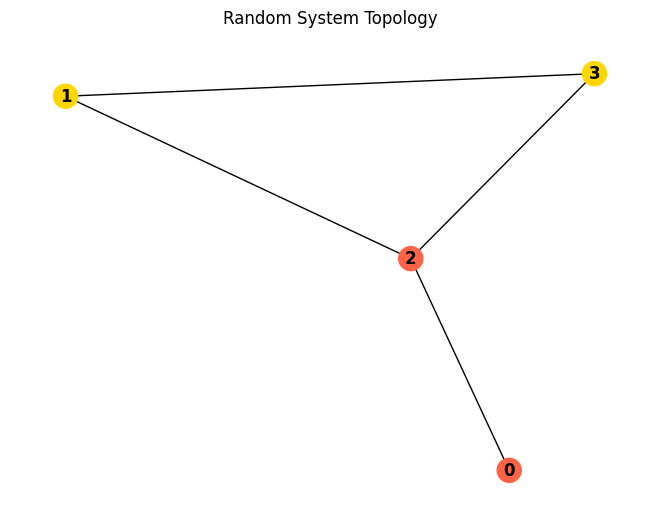

(4, 4, 3)


In [178]:
random_topology = generate_random_topology(4)
plot_topology(random_topology)
tva_topology = TVA(random_topology, vulns_exploits)
paths = find_paths(random_topology, 0, 1)
attack_paths = get_attack_paths(paths, tva_topology, 4)
controls = get_controls(attack_paths, exploits_controls, 4)
attack_paths = [str(path) for path in attack_paths] # tuples to strings
distributions_matrix = get_distributions_matrix(controls, attack_paths)
print(distributions_matrix.shape)

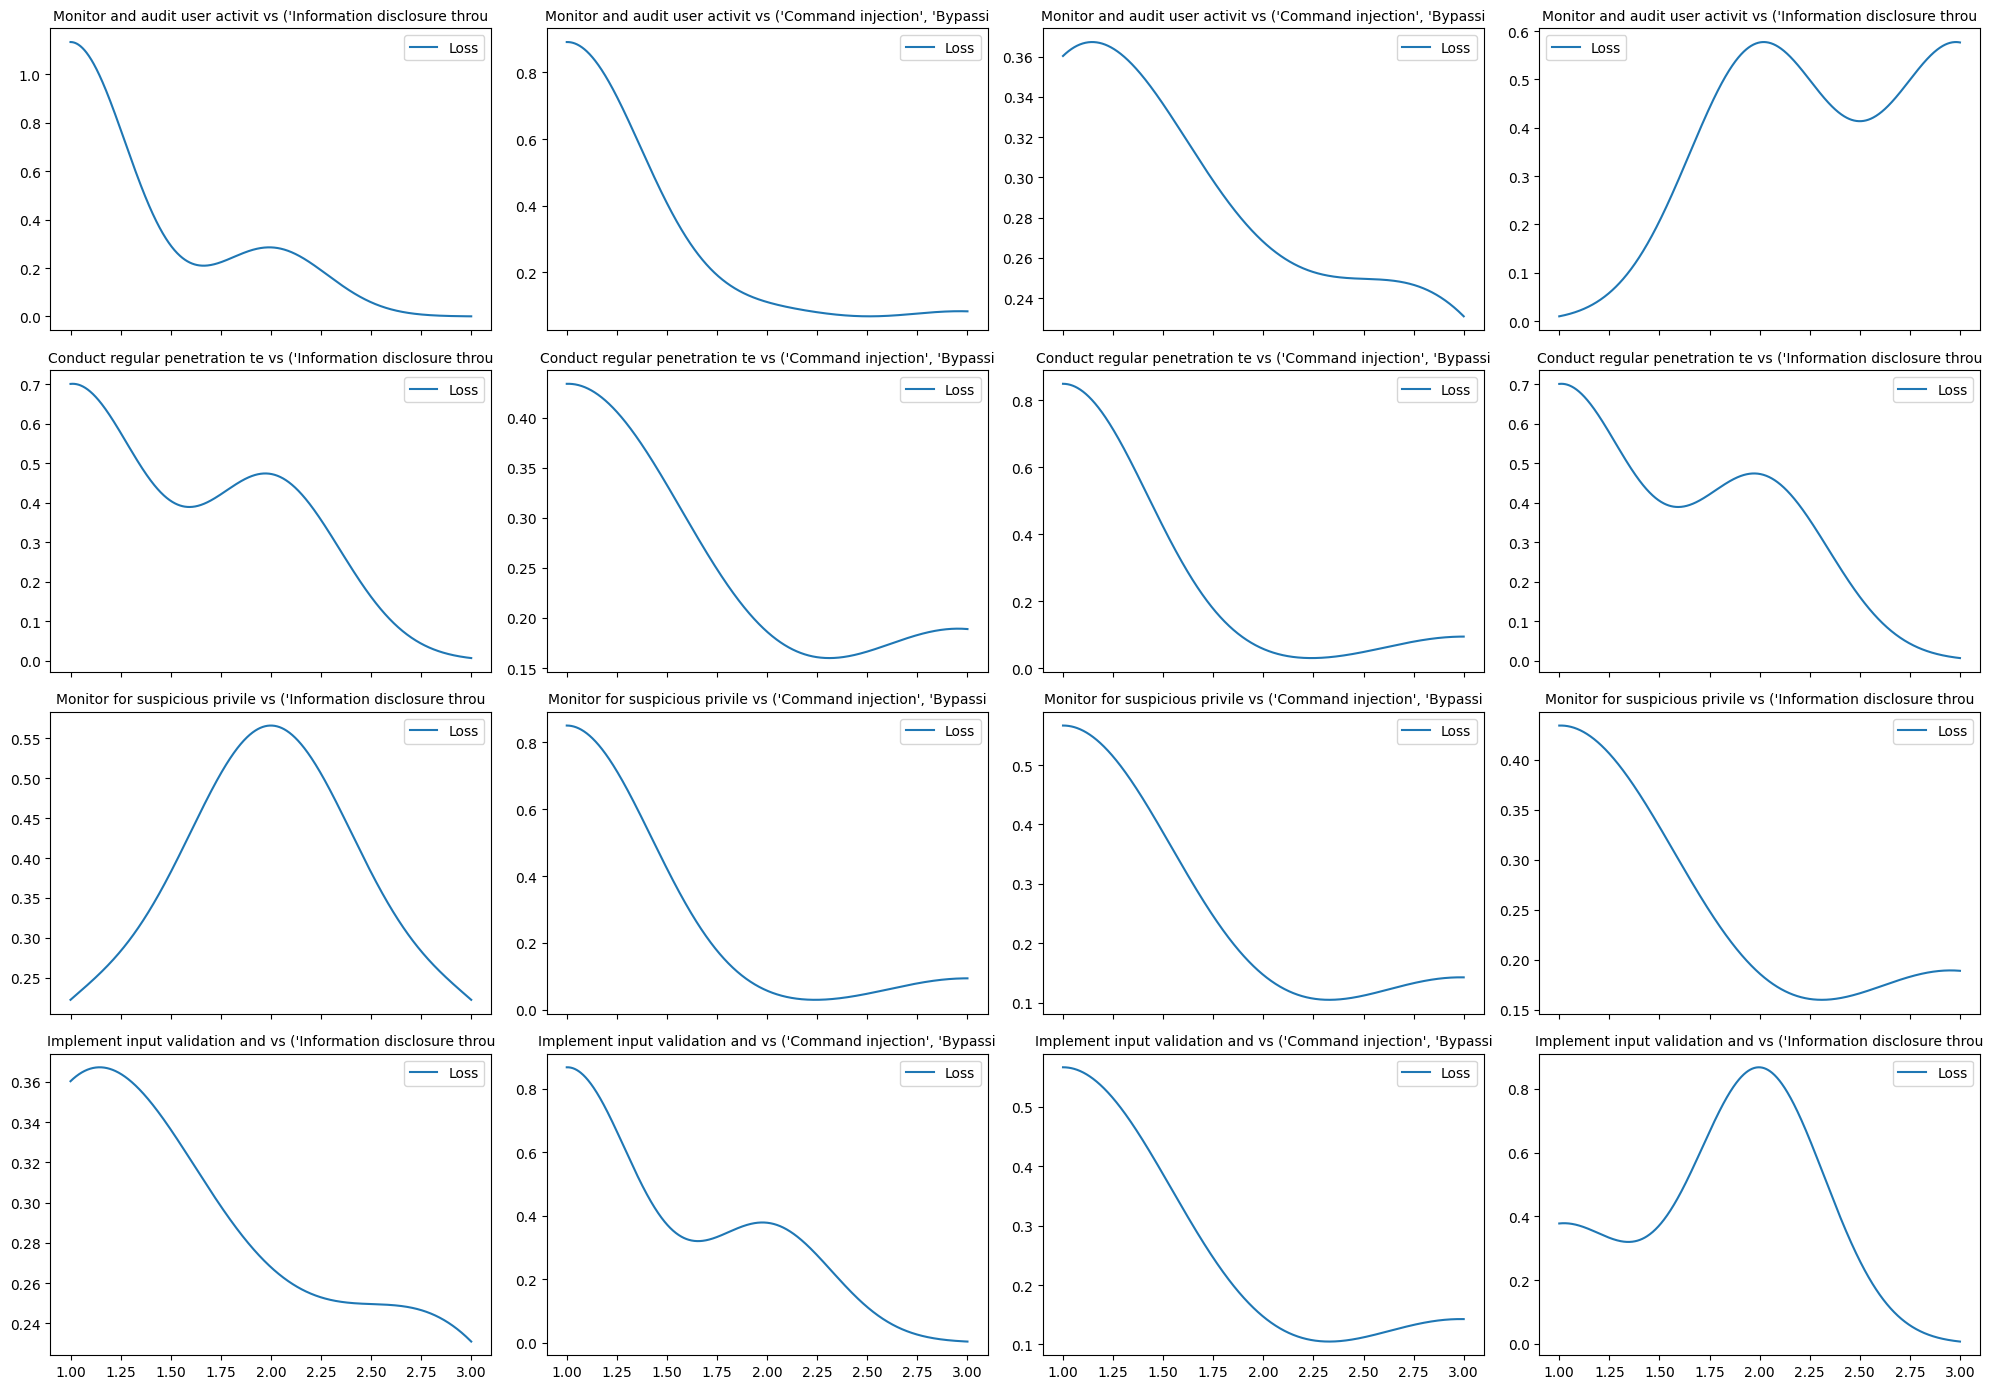

In [179]:
game_matrices, data = generate_game_matrices(distributions_matrix)

defender_strategies = controls
attacker_strategies = attack_paths

plot_KDE_curves(data, defender_strategies, attacker_strategies, size=(20, 14), title_fontsize=10)

In [181]:
p_star, q_star = fictitious_play(game_matrices)

print('Optimal Defense:\n')
for d_strategy, p_prob in zip(defender_strategies, p_star):
    print(f'{d_strategy}: {(p_prob * 100):.4f}% of the time')

print('\n\nExpected Attack:\n')
for a_strategy, q_prob in zip(attacker_strategies, q_star):
    print(f'{a_strategy}: {(q_prob * 100):.4f}% of the time')

Optimal Defense:

Monitor and audit user activities: 5.5000% of the time
Conduct regular penetration testing: 37.3000% of the time
Monitor for suspicious privilege changes: 57.1000% of the time
Implement input validation and output encoding: 0.1000% of the time


Expected Attack:

('Information disclosure through SSRF', 'Bypassing firewalls and filters', 'Privilege escalation', 'Cross-site Scripting (XSS)'): 13.4000% of the time
('Command injection', 'Bypassing firewalls and filters', 'Cross-site Scripting (XSS)'): 51.4000% of the time
('Command injection', 'Bypassing firewalls and filters', 'Privilege escalation', 'Unauthorized access to sensitive data'): 34.1000% of the time
('Information disclosure through SSRF', 'Bypassing firewalls and filters', 'Privilege escalation', 'Unauthorized access to sensitive data'): 1.1000% of the time
